## Lab 9: Predicting Forest Cover Type with SVMs

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/courses/EDS232/Data/covtype_sample.csv")

### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [2]:
X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

print(X.describe())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

          Elevation        Aspect         Slope  \
count  10000.000000  10000.000000  10000.000000   
mean    2955.599500    154.450000     14.114700   
std      281.786673    111.851861      7.499705   
min     1860.000000      0.000000      0.000000   
25%     2804.750000     58.000000      9.000000   
50%     2995.000000    126.000000     13.000000   
75%     3159.000000    258.000000     18.000000   
max     3846.000000    359.000000     65.000000   

       Horizontal_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      10000.000000                     10000.000000   
mean                         268.097600                        45.755300   
std                          211.899673                        58.034207   
min                            0.000000                      -164.000000   
25%                           95.000000                         7.000000   
50%                          218.000000                        29.000000   
75%     

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)

start_time = time.time()
grid_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

print("Best parameters:", grid_search.best_params_)
print("Time taken to fit grid search: {:.2f} seconds".format(elapsed_time))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=skf, n_jobs=-1, verbose=2)

start_time_rf = time.time()
grid_search_rf.fit(X_train, y_train)
end_time_rf = time.time()

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Time taken for GridSearchCV (Random Forest):", end_time_rf - start_time_rf, "seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Time taken for GridSearchCV (Random Forest): 8.706862449645996 seconds


### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


SVM Accuracy: 0.76
Random Forest Accuracy: 0.79


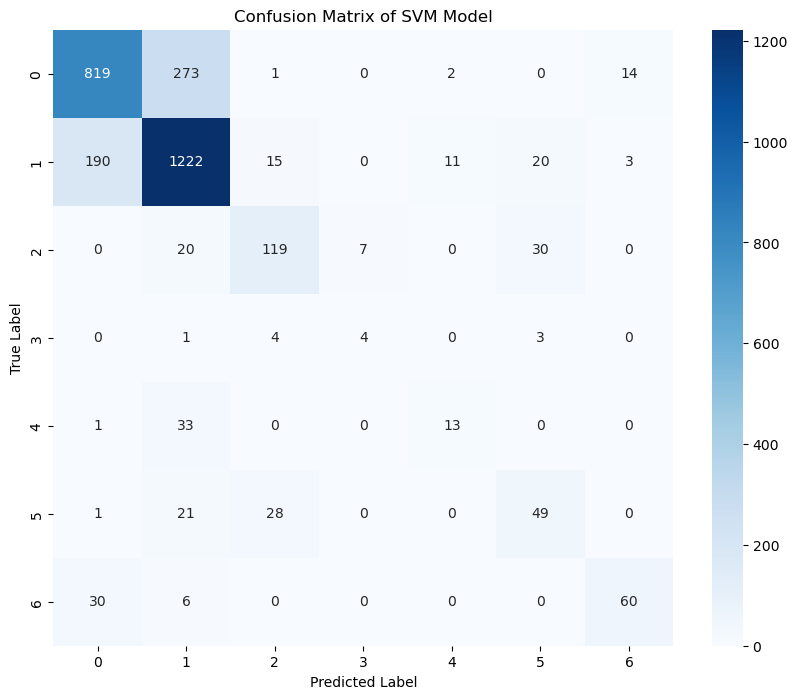

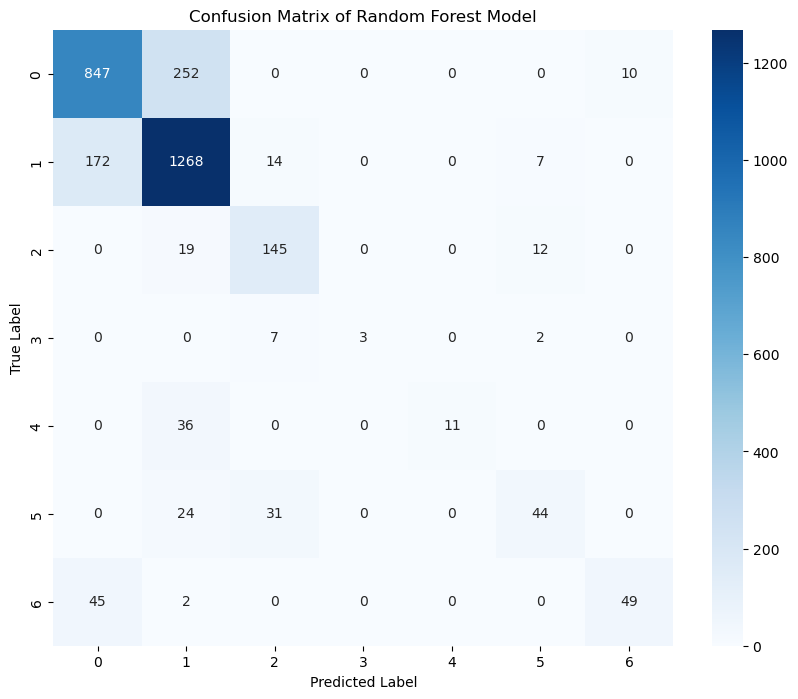

In [5]:
best_svm = grid_search.best_estimator_
best_rf = grid_search_rf.best_estimator_

y_pred_svm = best_svm.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()
plot_confusion_matrix(conf_matrix_svm, "Confusion Matrix of SVM Model")
plot_confusion_matrix(conf_matrix_rf, "Confusion Matrix of Random Forest Model")

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

SVM Model Performance:
Accuracy: 0.76
Training Time: 2.77 seconds

Random Forest Model Performance:
Accuracy: 0.79
Training Time: 2.22 seconds



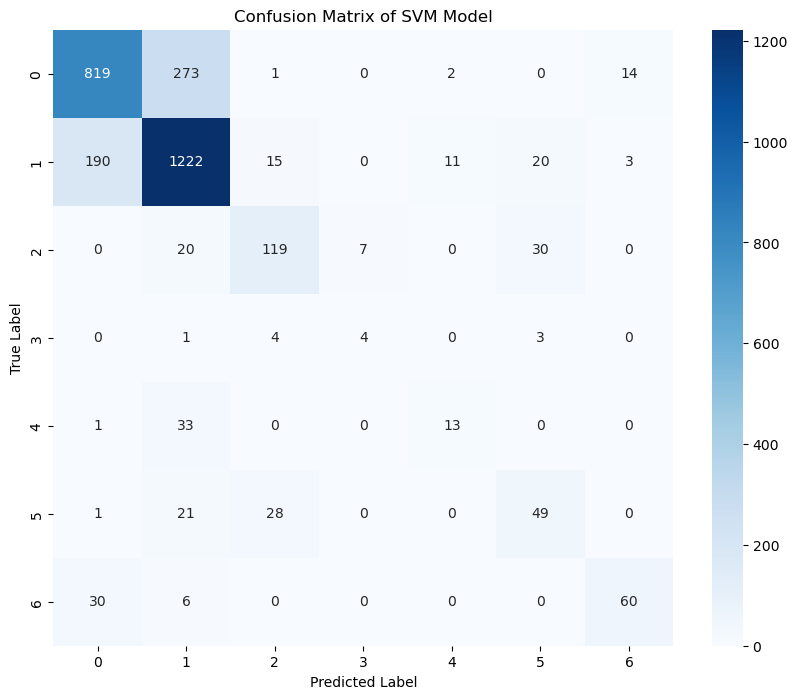

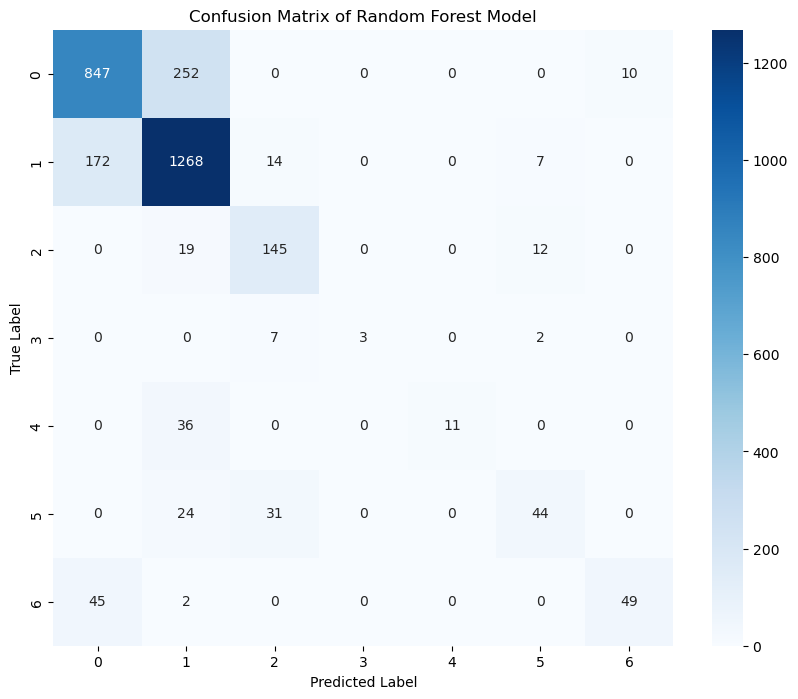

In [6]:
start_time_svm = time.time()
best_svm.fit(X_train, y_train)
end_time_svm = time.time()

y_pred_svm = best_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

start_time_rf = time.time()
best_rf.fit(X_train, y_train)
end_time_rf = time.time()

y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("SVM Model Performance:")
print(f"Accuracy: {accuracy_svm:.2f}")
print(f"Training Time: {end_time_svm - start_time_svm:.2f} seconds\n")
print("Random Forest Model Performance:")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Training Time: {end_time_rf - start_time_rf:.2f} seconds\n")

plot_confusion_matrix(conf_matrix_svm, "Confusion Matrix of SVM Model")
plot_confusion_matrix(conf_matrix_rf, "Confusion Matrix of Random Forest Model")

### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


The Random Forest model appears to be better for this data. It has a higher accuracy of 0.79 compared to the SVM’s 0.76, meaning it makes fewer mistakes. The Random Forest also trains faster, taking 2.20 seconds instead of 2.66 seconds. With better accuracy and quicker training time, the Random Forest model is a better choice. 